# Group 26 DSCI 100 Final Project

## Introduction

A UBC Computer Science research group, led by Frank Wood, is collecting data on how people play video games using a custom Minecraft server that records detailed player actions. Understanding player behaviour and activity levels is valuable both for research and for broader applications in the gaming industry. In particular, identifying which players tend to engage more heavily with a game can support targeted recruitment, improved study design, and more effective strategies for maintaining long-term engagement.

In this project, we aim to answer the following question: Can player characteristics, specifically experience level and age, predict the total hours a player has spent on the Minecraft server? Our goal is to determine whether these two easily collected features can distinguish between players with low, moderate, and high activity levels. 

Here is a breakdown of the players data:

Player data has 196 observations and 7 variables.

Two numerical:

  + played_hours: total hours played by an individual 
  + Age: age of player

Four character:

  + experience: level of the player ("Beginner", "Amateur", "Regular", "Veteran", "Pro")
  + hashedEmail: anonymized email for privacy.
  + name: player's first name
  + gender: player's gender

One logical:

  + subscribe: whether the player is subscribed to game-related newsletter


For the predictive analysis, we will focus on two key predictors: experience (which is converted to a 1-5 numeric scale) and age, to examine whether these characteristics relate to a player’s activity level. To model this relationship, we will use the K-Nearest Neighbours (KNN) algorithm, which is suitable for our analysis due to its ability to capture nonlinear patterns in data and its suitability for smaller datasets.

The optimal number of neighbours, k, will be selected using 5-fold cross-validation, with performance evaluated via accuracy and confusion matrices. This approach will allow us to assess whether simple demographic and experience-based features can meaningfully predict how active a player is, helping identify which types of players are most likely to contribute large amounts of gameplay data.

Thesis: We expect that both age and prior experience will meaningfully predict player activity levels, with these two features helping distinguish between players who contribute low, moderate, and high amounts of gameplay data.

## Methods and Results

### 1) Loading and Cleaning

In [2]:
library(tidyverse)
library(tidymodels)
players_url <- "https://raw.githubusercontent.com/averykimura/avery_gamet_project_planning_DSCI100/refs/heads/main/players.csv"
players <- read_csv(players_url, show_col_types = FALSE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
players <- rename(players, hashed_email = hashedEmail, age = Age) #variable names are all consistent

players <- select(players, age, played_hours, experience)
            #select only necessary variable

### 2) Preparing for Analysis

#### Summary Stats

In [4]:
players_summary <- summarise(players, 
  age_min = min(age, na.rm=TRUE),
  age_max = max(age, na.rm=TRUE),
  age_mean = mean(age, na.rm=TRUE),
  played_hours_min = min(played_hours, na.rm=TRUE),
  played_hours_max = max(played_hours, na.rm=TRUE),
  played_hours_mean = mean(played_hours, na.rm=TRUE),
  played_hours_median = median(played_hours, na.rm=TRUE))

                             
players_summary

age_min,age_max,age_mean,played_hours_min,played_hours_max,played_hours_mean,played_hours_median
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,58,21.13918,0,223.1,5.845918,0.1


Based on the summary statistics, player age ranges from 9 to 58 (years), with a mean of 21.14 (years), while total hours played range from 0 to 223.1 (hours), with a mean of 5.85 (hours). 

This means the played_hours distribution is extremely right-skewed. Most players have very low played hours while a small number have very high hours. This skew matters when choosing category sizes because using sized bins would group almost all players into the lowest category.


#### Creating Classifier Variable

In [5]:
players_hours <- players |>
    mutate(played_hours_group = case_when(played_hours <= 0 ~ "None", played_hours <= 1.5  ~ "Low", played_hours <= 4  ~ "Medium", TRUE ~ "High"))|>
    select(age, experience, played_hours_group)|>
    mutate(played_hours_group = factor(played_hours_group, levels = c("None", "Low", "Medium", "High")))

check <- players_hours |>
  count(played_hours_group)

players_factor <- mutate(players_hours, played_hours_group = factor(played_hours_group, levels = c("None", "Low", "Medium", "High")))

check

played_hours_group,n
<fct>,<int>
None,85
Low,81
Medium,15
High,15


Because the median played_hours was extremely low, we double-checked the distribution and found that a large number of observations had exactly 0 hours. To avoid having all of these lumped into the ‘low’ category, we created a separate ‘None’ category specifically for played_hours = 0. After that, we converted played_hours into a factor with ordered levels (None, Low, Medium, High) so it could be used as the response variable in our KNN classification.

#### Wrangling Predictors

In [6]:
players_ready <- players_factor |>
    mutate(experience = factor(experience,
                        levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
                        ordered = TRUE),
                        experience_score = as.numeric(experience))|>
    select(played_hours_group, age, experience_score)|>
    filter(!is.na(age))

Since KNN requires numerical predictors, we converted the experience variable into a 1–5 numeric scale. We also removed the two observations with missing age categories, as they prevented the predictors from being fully numeric. After these adjustments, the dataset was fully wrangled and ready for KNN classification.

#### Visualization

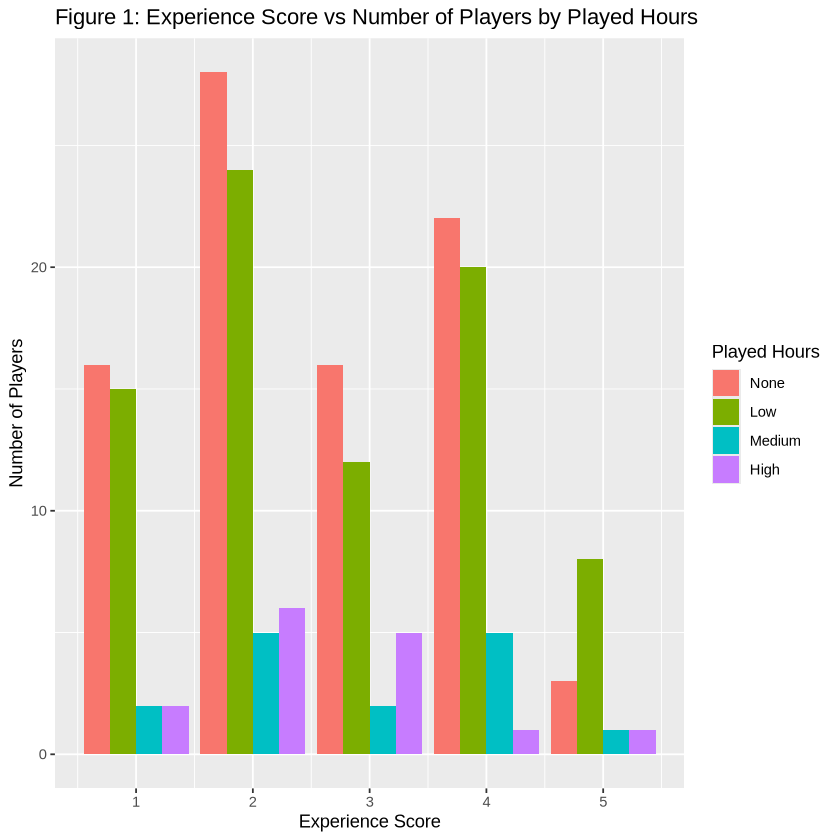

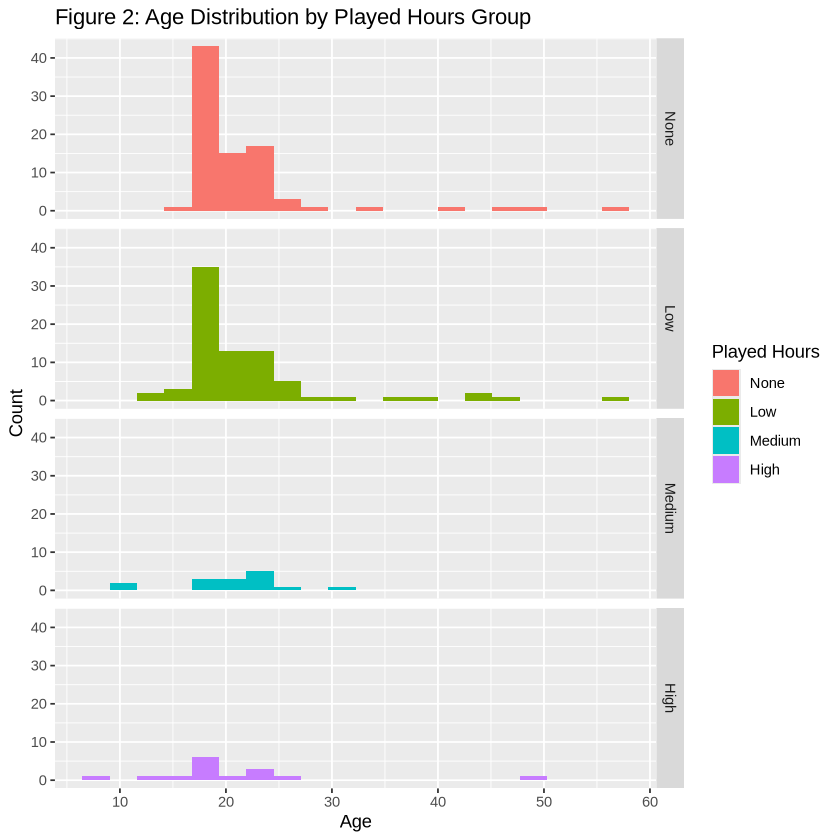

In [25]:
figure1 <- ggplot(players_ready, aes(x = experience_score, fill = played_hours_group)) +
  geom_bar(position = "dodge") +
  labs(x = "Experience Score", y = "Number of Players", fill = "Played Hours", title="Figure 1: Experience Score vs Number of Players by Played Hours")

figure2 <- ggplot(players_ready, aes(x = age, fill = played_hours_group)) +
  facet_grid(rows = vars(played_hours_group))+
  geom_histogram(position = "identity", bins = 20) +
  labs(x = "Age", y = "Count", fill = "Played Hours", title="Figure 2: Age Distribution by Played Hours Group")

figure1
figure2

Figure 1 shows the distribution of played_hours_group across different experience_score categories. It is evident that the “none” and “low” classes dominate all experience levels, indicating that experience_score alone provides limited separation between classes.

Figure 2 presents the age distribution by played_hours_group. Similar to experience, only the “none” and “low” categories have enough observations for meaningful visualization, and the data for all classes is heavily clustered between 15 and 25 years old. This overlap suggests that age alone also does not strongly differentiate classes.

Since KNN relies on distances between observations, the overlapping distributions of both age and experience_score indicate that classification is likely to be challenging. With only these two predictors, areas where multiple classes share similar age and experience values may lead to ambiguous predictions. Standardizing these predictors is necessary so that KNN can fairly combine age and experience differences when computing distances.

### 3) KNN Classification 

#### Split and Preprocess Data

In [28]:
set.seed(2000)

players_split <- initial_split(players_ready, prop=0.75, strata=played_hours_group)
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(played_hours_group ~., data=players_train)|>
                step_center(all_predictors())|>
                step_scale(all_predictors())

The dataset was split into training (75%) and test (25%) sets, and all predictors were centered and scaled using a recipe to prepare for KNN, which requires standardized numeric data to calculate distances accurately between observations.

#### Cross Validation and Picking K

In [29]:
set.seed(2000)
tune_model <- nearest_neighbor(weight_func = "rectangular", neighbors=tune())|>
        set_engine("kknn")|>
        set_mode("classification")


v_fold <- vfold_cv(players_train, v=5, strata=played_hours_group)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 2))

results <- workflow() |>
       add_recipe(players_recipe) |>
       add_model(tune_model) |>
        tune_grid(resamples = v_fold, grid = k_vals) |>
        collect_metrics()

accuracies <- results |> 
      filter(.metric == "accuracy")

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
accuracies
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3382430,5,0.02111295,Preprocessor1_Model1
3,accuracy,multiclass,0.2906404,5,0.03318681,Preprocessor1_Model2
5,accuracy,multiclass,0.3049261,5,0.03564070,Preprocessor1_Model3
7,accuracy,multiclass,0.3794417,5,0.04956783,Preprocessor1_Model4
9,accuracy,multiclass,0.3858621,5,0.05107744,Preprocessor1_Model5


[1] 9

To select the optimal number of neighbors (k) for the KNN classifier, we performed 5-fold cross-validation on the training set. The training data was divided into 5 folds, and candidate k values from 1 to 10 (in increments of 2) were tested. Accuracy was used as the performance metric to evaluate each candidate. After comparing all values, k = 9 was selected as it achieved the highest mean cross-validation accuracy.

#### Determine Model Accuracy

In [30]:
set.seed(2000)
players_model <- nearest_neighbor(weight_func="rectangular", neighbors=9)|>
                set_engine("kknn")|>
                set_mode("classification")   

players_fit <- workflow() |>
       add_recipe(players_recipe) |>
       add_model(players_model) |>
       fit(data = players_train)

players_predict <- predict(players_fit, players_test)|>
                    bind_cols(players_test)

players_accuracy<- players_predict|>
                    accuracy(truth=played_hours_group, estimate=.pred_class)

players_precision<- players_predict|>
                    precision(truth=played_hours_group, estimate=.pred_class, event_level="first")

players_recall<- players_predict|>
                    recall(truth=played_hours_group, estimate=.pred_class, event_level="first")

players_confmat<- players_predict|>
                    conf_mat(truth=played_hours_group, estimate=.pred_class)

players_accuracy
players_precision
players_recall
players_confmat

Warning message:
“While computing multiclass `precision()`, some levels had no predicted events
(i.e. `true_positive + false_positive = 0`).
Precision is undefined in this case, and those levels will be removed from the
averaged result.
Note that the following number of true events actually occurred for each
problematic event level:
'Medium': 4, 'High': 3”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.3061224


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.311828


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,macro,0.1836384


          Truth
Prediction None Low Medium High
    None      6  10      0    2
    Low      17   9      4    1
    Medium    0   0      0    0
    High      0   0      0    0

After training the final KNN model on the training set, we used it to predict played_hours_group for the test set. The predictions were combined with the true values to evaluate model performance. We calculated accuracy, precision, recall, and constructed a confusion matrix to understand how well the model classified each activity level.

#### Visualize Results

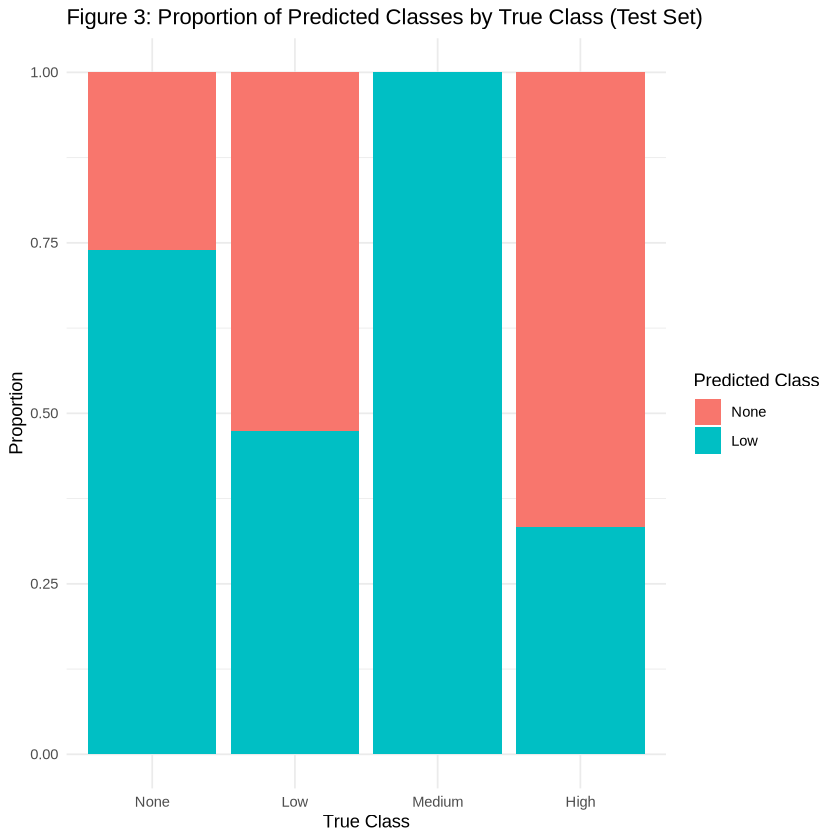

In [45]:
figure3 <- ggplot(players_predict, aes(x = played_hours_group, fill = .pred_class)) +
  geom_bar(position = "fill") +  
  labs(
    x = "True Class",
    y = "Proportion",
    fill = "Predicted Class",
    title = "Figure 3: Proportion of Predicted Classes by True Class (Test Set)"
  ) +
  theme_minimal()

figure3

Figure 3 shows the proportion of predicted classes for each true played_hours_group in the test set. The visualization makes it immediately clear that the KNN model primarily predicts the “None” and “Low” classes, while the “Medium” and “High” classes are never predicted. Even within the more common classes, there is substantial misclassification: many true “None” observations are predicted as “Low,” and many true “Low” observations are predicted as “None.”

This pattern reflects two key issues: first, the predictors do not provide sufficient separation between classes, and second, class imbalance exacerbates the problem, causing KNN to favor the dominant classes. Overall, this figure demonstrates that, with only these two predictors, KNN struggles to accurately classify the data and highlights the limitations of the current predictors.


## Discussion

#### Summary of Findings.
Even after rebalancing the played-hours categories by creating a separate None group and spreading the remaining players into Low, Medium, and High, the KNN model still predicted almost exclusively the majority classes. The confusion matrix showed that nearly all predictions fell into None or Low, with no correct predictions for Medium or High. Model metrics confirmed this pattern: the best model achieved an accuracy of 0.306, precision of 0.312, and recall of only 0.184, displaying consistently poor performance for minority categories.

#### Whether This Was Expected.
While in our introduction we hypothesized that age and experience would be good predictors of played hours, once we computed the initial summary statistics, we began to realize the major skew toward players with very low or no played hours. From the beginning, the dataset contained far fewer Medium and High players, and age and experience showed weak separation across these groups. Given this imbalance and lack of distinct patterns, it was predictable that KNN would struggle, especially with recall, despite attempts to rebalance the categories.

#### Impact of These Findings.
For the research group’s recruitment strategy, these findings suggest that age and experience are not useful indicators for identifying high-engagement players. Relying on these characteristics would not help target participants who contribute substantial gameplay data. This highlights the need for more informative predictors, such as in-game behavior, play frequency, or indicators of player motivation, to better identify target participants.

#### Future Questions and Directions.
These findings raise several follow-up questions. What additional features might better predict activity level? Would modeling played hours as a continuous variable improve results? And could alternative methods that can handle imbalance more effectively improve predictive power? Exploring these directions may lead to models that more accurately identify highly engaged players.